# Pandas

```
conda install pandas matplotlib
```

_(and numpy from before)_

Let's go back to the very first problem from this morning. We have an incomplete record of Newark temperatures since 1893.

In [1]:
import numpy
temperatures = numpy.loadtxt("data/newark-temperature-avg.txt")
temperatures

array([nan, nan, nan, ..., 68., 59., 47.])

But instead of analyzing it with raw Numpy, let's use Pandas.

In [2]:
import pandas
temperatures = pandas.Series(temperatures)
temperatures

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        NaN
         ... 
41989    65.0
41990    71.0
41991    69.0
41992    70.0
41993    73.0
41994    73.0
41995    63.0
41996    52.0
41997    51.0
41998    58.0
41999    56.0
42000    52.0
42001    48.0
42002    47.0
42003    56.0
42004     NaN
42005    43.0
42006    53.0
42007    50.0
42008    46.0
42009    43.0
42010    47.0
42011    49.0
42012    52.0
42013    48.0
42014    52.0
42015    62.0
42016    68.0
42017    59.0
42018    47.0
Length: 42019, dtype: float64

Numpy was designed to do fast calculations with minimal dependencies.

Pandas was designed to make a data analyst's life easier.

In [3]:
%matplotlib inline

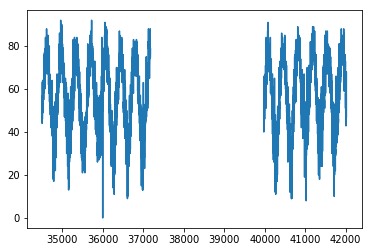

In [4]:
temperatures.plot()

Behold the turning of the seasons!

You can think of a Pandas Series as a Numpy array with bells and whistles, but it's more than that.

It is an _indexed_ Numpy array with bells and whistles.

In [5]:
temperatures.index

RangeIndex(start=0, stop=42019, step=1)

In [6]:
temperatures.index = numpy.loadtxt("data/newark-days-ago.txt")
temperatures.index.name = "days ago"

In [7]:
temperatures.index

Float64Index([-45962.0, -45961.0, -45960.0, -45959.0, -45958.0, -45957.0,
              -45956.0, -45955.0, -45954.0, -45953.0,
              ...
                  -9.0,     -8.0,     -7.0,     -6.0,     -5.0,     -4.0,
                  -3.0,     -2.0,     -1.0,      0.0],
             dtype='float64', name='days ago', length=42019)

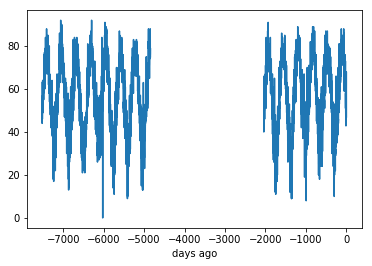

In [8]:
temperatures.plot()

In [9]:
temperatures.index = pandas.to_datetime(temperatures.index, unit="D", origin=pandas.Timestamp("2018-11-04"))
temperatures.index.name = "date"
temperatures.index

DatetimeIndex(['1893-01-01', '1893-01-02', '1893-01-03', '1893-01-04',
               '1893-01-05', '1893-01-06', '1893-01-07', '1893-01-08',
               '1893-01-09', '1893-01-10',
               ...
               '2018-10-26', '2018-10-27', '2018-10-28', '2018-10-29',
               '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02',
               '2018-11-03', '2018-11-04'],
              dtype='datetime64[ns]', name='date', length=42019, freq=None)

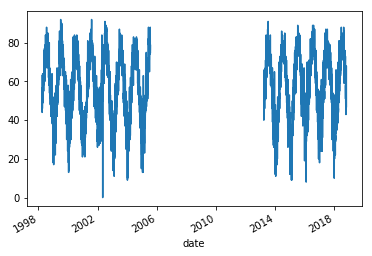

In [10]:
temperatures.plot()

Now let's return to the problem of imputing the missing temperature data.

In [11]:
min_temperatures = pandas.Series(numpy.loadtxt("data/newark-temperature-min.txt"))
max_temperatures = pandas.Series(numpy.loadtxt("data/newark-temperature-max.txt"))
min_temperatures.index = temperatures.index
max_temperatures.index = temperatures.index

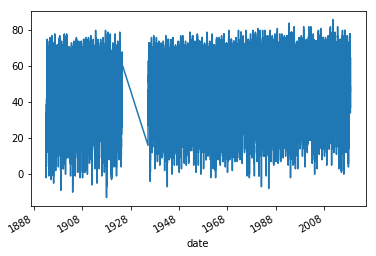

In [12]:
min_temperatures.plot()

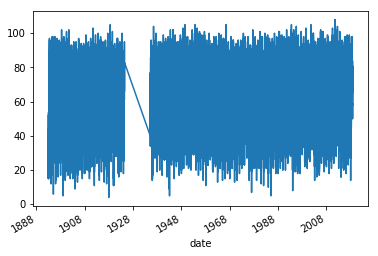

In [13]:
max_temperatures.plot()

It would be more convenient if these were in the same object. A DataFrame is several Series glued together with a common index.

In [14]:
df = pandas.concat([temperatures, min_temperatures, max_temperatures], axis="columns")
df.columns = ["avg", "min", "max"]   # name them!
df

,avg,min,max
date,,,
1893-01-01,NaN,26.0,52.0
1893-01-02,NaN,34.0,43.0
1893-01-03,NaN,17.0,32.0
1893-01-04,NaN,13.0,23.0
1893-01-05,NaN,17.0,27.0
1893-01-06,NaN,13.0,30.0
1893-01-07,NaN,12.0,28.0
1893-01-08,NaN,15.0,28.0
1893-01-09,NaN,11.0,32.0


Performing calculations on columns of a DataFrame is very much like Numpy: all of the elementwise operations, masking, and fancy indexing apply. In fact, Pandas usually just passes off this work on Numpy. However, it _organizes_ that work.

In [15]:
df["min-max avg"] = (df["min"] + df["max"]) / 2
df

,avg,min,max,min-max avg
date,,,,
1893-01-01,NaN,26.0,52.0,39.0
1893-01-02,NaN,34.0,43.0,38.5
1893-01-03,NaN,17.0,32.0,24.5
1893-01-04,NaN,13.0,23.0,18.0
1893-01-05,NaN,17.0,27.0,22.0
1893-01-06,NaN,13.0,30.0,21.5
1893-01-07,NaN,12.0,28.0,20.0
1893-01-08,NaN,15.0,28.0,21.5
1893-01-09,NaN,11.0,32.0,21.5


Although we could have repeated the Numpy method of masking by `numpy.isnan(df["avg"])`, Pandas has functions for dealing with missing data. (A lot of them, actually.)

In [16]:
df["imputed"] = df["avg"].fillna(df["min-max avg"])
df

,avg,min,max,min-max avg,imputed
date,,,,,
1893-01-01,NaN,26.0,52.0,39.0,39.0
1893-01-02,NaN,34.0,43.0,38.5,38.5
1893-01-03,NaN,17.0,32.0,24.5,24.5
1893-01-04,NaN,13.0,23.0,18.0,18.0
1893-01-05,NaN,17.0,27.0,22.0,22.0
1893-01-06,NaN,13.0,30.0,21.5,21.5
1893-01-07,NaN,12.0,28.0,20.0,20.0
1893-01-08,NaN,15.0,28.0,21.5,21.5
1893-01-09,NaN,11.0,32.0,21.5,21.5


We can select columns by strings in square brackets (like Numpy's record arrays, a feature I didn't show you), but rows cannot be selected by integer index.

Whereas an array of length `N` is a function `[0, N) → V`, a DataFrame is a function `K → V1×V2×V3`, where `K` is the index and `V1×V2×V3` are the columns. Integer indexing won't work unless the index has integer type:

In [17]:
try:
    df[-1]
except KeyError:
    print("Nope, -1 is not a valid index for this DataFrame.")

Nope, -1 is not a valid index for this DataFrame.


But unlike an SQL table, a DataFrame index has an ordering. We should be able to ask for the last element, so there's a special accessor for that: `iloc`.

In [18]:
df.iloc[-1]

avg            47.0
min             NaN
max             NaN
min-max avg     NaN
imputed        47.0
Name: 2018-11-04 00:00:00, dtype: float64

But generally, the index type should be more meaningful than the positions, so we'd want to access rows by index elements. That's `loc`.

In [19]:
df.loc[pandas.Timestamp("2018-11-04")]

avg            47.0
min             NaN
max             NaN
min-max avg     NaN
imputed        47.0
Name: 2018-11-04 00:00:00, dtype: float64

We can slice regions of time just as we slice integer indexes.

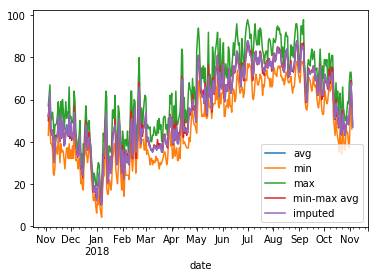

In [20]:
df.loc[pandas.Timestamp("2017-11-04"):].plot()

And that lets us zoom into interesting regions in the data space.

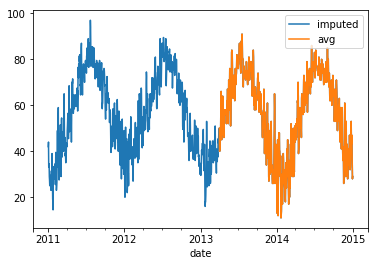

In [21]:
df[["imputed", "avg"]].loc[pandas.Timestamp("2011-01-01"):pandas.Timestamp("2015-01-01")].plot()

Pandas has oodles of statistical functions. Whenever I want to do something, I do a web search to find out what it's named— _somebody's_ asked about it on StackOverflow.

Let's look for local warming! (Not global; this is just Newark.)

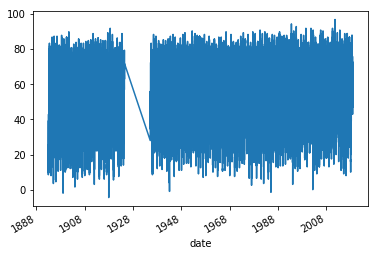

In [22]:
df["imputed"].plot()

Day-to-day variations are drowning out any effect. Can we smooth these data?

Yes. It's called a rolling mean.

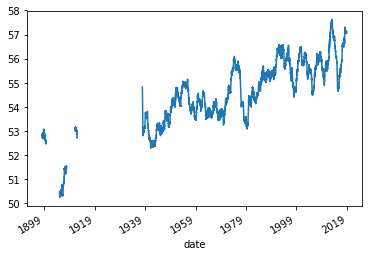

In [23]:
df["imputed"].rolling(3*365).mean().plot()

The input files we've been working with are artificial (one number per line as text). The original file that came from the NCDC was a CSV with redundant information.

In [24]:
df2 = pandas.read_csv("data/newark-temperature.csv")
df2

,STATION,NAME,DATE,TAVG,TMAX,TMIN
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-01,NaN,52.0,26.0
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-02,NaN,43.0,34.0
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-03,NaN,32.0,17.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-04,NaN,23.0,13.0
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-05,NaN,27.0,17.0
5,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-06,NaN,30.0,13.0
6,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-07,NaN,28.0,12.0
7,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-08,NaN,28.0,15.0
8,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-09,NaN,32.0,11.0
9,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1893-01-10,NaN,32.0,4.0


The first two columns have only one value because this was a database selection. Pandas's `read_csv` function recognized that the temperature columns are numbers, but not that the date is a date.

In [25]:
df2["DATE"].dtype

dtype('O')

The `'O'` type (object) is for cases when Pandas doesn't recognize the type of a field. In principle, it could be any Python object, but from a CSV file, it's a string.

We can try to read it again, this time providing a hint that this column is supposed to be a date.

In [26]:
df2 = pandas.read_csv("data/newark-temperature.csv", parse_dates=["DATE"])
df2.columns

Index(['STATION', 'NAME', 'DATE', 'TAVG', 'TMAX', 'TMIN'], dtype='object')

It has the same columns, but now the date is a date.

In [27]:
df2["DATE"].dtype

dtype('<M8[ns]')

We'd like this date column to be the index of the whole table, so we say so.

In [28]:
df2.index = df2["DATE"]

Now we can do the same analysis we did before, but directly on the DataFrame from the CSV file, not by gluing together Series derived from Numpy arrays.

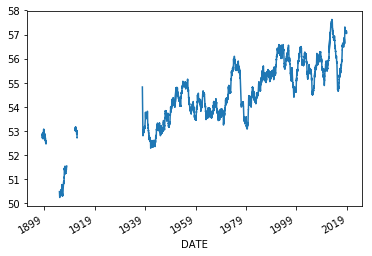

In [29]:
df2["imputed"] = df2["TAVG"].fillna((df2["TMIN"] + df2["TMAX"]) / 2)
df2["imputed"].rolling(3*365).mean().plot()

Temperature data are fairly simple: a one-dimensional time series. Let's consider something with a bit more structure— exoplanets.

Each star may have a different number of planets, which complicates the indexing.

In [30]:
planets = pandas.read_csv("data/nasa-exoplanets.csv")
planets

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_pnum,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,...,st_bmvj,st_vjmic,st_vjmrc,st_jmh2,st_hmk2,st_jmk2,st_bmy,st_m1,st_c1,st_colorn
0,1,11 Com,b,11 Com b,Radial Velocity,1,326.030000,1.290000,0.2310,NaN,...,1.010,NaN,NaN,0.459,0.202,0.661,NaN,NaN,NaN,7
1,2,11 UMi,b,11 UMi b,Radial Velocity,1,516.219970,1.530000,0.0800,NaN,...,1.369,NaN,NaN,0.785,0.152,0.937,NaN,NaN,NaN,5
2,3,14 And,b,14 And b,Radial Velocity,1,185.840000,0.830000,0.0000,NaN,...,1.020,NaN,NaN,0.411,0.277,0.688,NaN,NaN,NaN,7
3,4,14 Her,b,14 Her b,Radial Velocity,1,1773.400020,2.930000,0.3700,NaN,...,0.880,NaN,NaN,0.355,0.089,0.444,0.537,0.366,0.438,9
4,5,16 Cyg B,b,16 Cyg B b,Radial Velocity,1,798.500000,1.660000,0.6800,NaN,...,0.660,NaN,NaN,0.298,0.044,0.342,0.418,0.222,0.351,17
5,6,18 Del,b,18 Del b,Radial Velocity,1,993.300000,2.600000,0.0800,NaN,...,0.924,NaN,NaN,0.592,0.074,0.666,NaN,NaN,NaN,5
6,7,1RXS J160929.1-210524,b,1RXS J160929.1-210524 b,Imaging,1,NaN,330.000000,NaN,NaN,...,NaN,NaN,NaN,0.699,0.205,0.904,NaN,NaN,NaN,3
7,8,24 Boo,b,24 Boo b,Radial Velocity,1,30.350600,0.190000,0.0420,NaN,...,0.864,NaN,NaN,0.505,0.181,0.686,NaN,NaN,NaN,6
8,9,24 Sex,b,24 Sex b,Radial Velocity,2,452.800000,1.333000,0.0900,NaN,...,0.958,NaN,NaN,0.806,0.201,1.007,0.572,0.342,0.427,8
9,10,24 Sex,c,24 Sex c,Radial Velocity,2,883.000000,2.080000,0.2900,NaN,...,0.958,NaN,NaN,0.806,0.201,1.007,0.572,0.342,0.427,8


Not knowing much about this dataset, let's get a quick summary of the columns.

In [31]:
planets.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowid,3837.0,1.919000e+03,1107.790820,1.000000e+00,9.600000e+02,1.919000e+03,2.878000e+03,3.837000e+03
pl_pnum,3837.0,1.770915e+00,1.165819,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,8.000000e+00
pl_orbper,3738.0,2.384170e+03,119779.613863,9.070629e-02,4.578109e+00,1.189665e+01,4.179196e+01,7.300000e+06
pl_orbsmax,2184.0,6.923161e+00,83.766445,4.400000e-03,5.800000e-02,1.190000e-01,6.900000e-01,2.500000e+03
pl_orbeccen,1210.0,1.678897e-01,0.193969,0.000000e+00,1.500000e-02,1.000000e-01,2.500000e-01,9.700000e-01
pl_orbincl,713.0,8.612205e+01,7.953407,7.700000e+00,8.605000e+01,8.800000e+01,8.924000e+01,9.076000e+01
pl_bmassj,1428.0,2.610171e+00,4.519508,6.000000e-05,1.600000e-01,9.320000e-01,2.692500e+00,5.559000e+01
pl_radj,3027.0,3.626204e-01,0.415711,3.000000e-02,1.395000e-01,2.060000e-01,3.050000e-01,6.900000e+00
pl_dens,395.0,2.490461e+00,5.210906,3.000000e-02,4.100000e-01,9.800000e-01,2.500000e+00,7.770000e+01
pl_ttvflag,3837.0,6.176701e-02,0.240763,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Fortunately, NASA gave us longer explanations of the column names.

In [32]:
!cat data/nasa-exoplanets-details.txt

# This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
# Fri Nov  9 17:35:38 2018
#
# COLUMN pl_hostname:    Host Name
# COLUMN pl_letter:      Planet Letter
# COLUMN pl_name:        Planet Name
# COLUMN pl_discmethod:  Discovery Method
# COLUMN pl_pnum:        Number of Planets in System
# COLUMN pl_orbper:      Orbital Period [days]
# COLUMN pl_orbsmax:     Orbit Semi-Major Axis [AU])
# COLUMN pl_orbeccen:    Eccentricity
# COLUMN pl_orbincl:     Inclination [deg]
# COLUMN pl_bmassj:      Planet Mass or M*sin(i) [Jupiter mass]
# COLUMN pl_bmassprov:   Planet Mass or M*sin(i) Provenance
# COLUMN pl_radj:        Planet Radius [Jupiter radii]
# COLUMN pl_dens:        Planet Density [g/cm**3]
# COLUMN pl_ttvflag:     TTV Flag
# COLUMN pl_kepflag:     Kepler Field Flag
# COLUMN pl_k2flag:      K2 Mission Flag
# COLUMN pl_nnotes:      Number of Notes
# COLUMN ra_str:         RA [sexagesimal]
# COLUMN ra:             RA [decimal degrees]
# COLUMN de

Number of moons? ("`pl_mnum`: Number of Moons in System") Awesome!

In [33]:
planets[planets["pl_mnum"] > 0]

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_pnum,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,...,st_bmvj,st_vjmic,st_vjmrc,st_jmh2,st_hmk2,st_jmk2,st_bmy,st_m1,st_c1,st_colorn


I guess not yet. They're just being hopeful.

In this dataset, one row is one planet. Thus, star data for stars with multiple known planets are duplicated (which effectively weights star data by their number of planets in `planets.describe()`).

To get a table of stars only, we'd have to do a group-by. We expect the star data to be the same for each planet associated with a star, so the mean is an appropriate summary.

In [34]:
planets.groupby("pl_hostname").mean()

,rowid,pl_pnum,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,pl_bmassj,pl_radj,pl_dens,pl_ttvflag,...,st_bmvj,st_vjmic,st_vjmrc,st_jmh2,st_hmk2,st_jmk2,st_bmy,st_m1,st_c1,st_colorn
pl_hostname,,,,,,,,,,,,,,,,,,,,,
11 Com,1.0,1.0,326.030000,1.290000,0.231000,NaN,19.400000,NaN,NaN,0.0,...,1.010,NaN,NaN,0.459,0.202,0.661,NaN,NaN,NaN,7.0
11 UMi,2.0,1.0,516.219970,1.530000,0.080000,NaN,14.740000,NaN,NaN,0.0,...,1.369,NaN,NaN,0.785,0.152,0.937,NaN,NaN,NaN,5.0
14 And,3.0,1.0,185.840000,0.830000,0.000000,NaN,4.800000,NaN,NaN,0.0,...,1.020,NaN,NaN,0.411,0.277,0.688,NaN,NaN,NaN,7.0
14 Her,4.0,1.0,1773.400020,2.930000,0.370000,NaN,4.660000,NaN,NaN,0.0,...,0.880,NaN,NaN,0.355,0.089,0.444,0.537,0.366,0.438,9.0
16 Cyg B,5.0,1.0,798.500000,1.660000,0.680000,NaN,1.780000,NaN,NaN,0.0,...,0.660,NaN,NaN,0.298,0.044,0.342,0.418,0.222,0.351,17.0
18 Del,6.0,1.0,993.300000,2.600000,0.080000,NaN,10.300000,NaN,NaN,0.0,...,0.924,NaN,NaN,0.592,0.074,0.666,NaN,NaN,NaN,5.0
1RXS J160929.1-210524,7.0,1.0,NaN,330.000000,NaN,NaN,8.000000,NaN,NaN,0.0,...,NaN,NaN,NaN,0.699,0.205,0.904,NaN,NaN,NaN,3.0
24 Boo,8.0,1.0,30.350600,0.190000,0.042000,NaN,0.910000,NaN,NaN,0.0,...,0.864,NaN,NaN,0.505,0.181,0.686,NaN,NaN,NaN,6.0
24 Sex,9.5,2.0,667.900000,1.706500,0.190000,NaN,1.425000,NaN,NaN,0.0,...,0.958,NaN,NaN,0.806,0.201,1.007,0.572,0.342,0.427,8.0


**Exercise:** This reduction averages all values per star, which is not meaningful for planet variables (which start with `"pl_"`). After all, what does it mean to average their "semi-major axes?" Or their "discovery methods?"

To avoid confusion, repeat the group-by with only the columns that start with `"st_"`.

In [35]:
planets.groupby("pl_hostname")[[x for x in planets.columns if x.startswith("st_")]].mean()

,st_dist,st_optmag,st_teff,st_mass,st_rad,st_rah,st_glon,st_glat,st_elon,st_elat,...,st_bmvj,st_vjmic,st_vjmrc,st_jmh2,st_hmk2,st_jmk2,st_bmy,st_m1,st_c1,st_colorn
pl_hostname,,,,,,,,,,,,,,,,,,,,,
11 Com,93.37,4.740,4742.0,2.70,19.00,12.345285,264.140892,78.280522,177.422388,18.333765,...,1.010,NaN,NaN,0.459,0.202,0.661,NaN,NaN,NaN,7
11 UMi,125.72,5.016,4213.0,2.78,29.79,15.284969,108.718982,41.044516,141.647144,74.958184,...,1.369,NaN,NaN,0.785,0.152,0.937,NaN,NaN,NaN,5
14 And,75.59,5.227,4813.0,2.20,11.00,23.521505,106.411558,-21.050610,11.962116,38.229937,...,1.020,NaN,NaN,0.411,0.277,0.688,NaN,NaN,NaN,7
14 Her,17.94,6.610,5338.0,0.90,0.93,16.173420,69.170376,46.944999,223.248728,62.879798,...,0.880,NaN,NaN,0.355,0.089,0.444,0.537,0.366,0.438,9
16 Cyg B,21.41,6.250,5750.0,1.08,1.13,19.697770,83.336460,13.204352,321.218050,69.468372,...,0.660,NaN,NaN,0.298,0.044,0.342,0.418,0.222,0.351,17
18 Del,76.38,5.506,4979.0,2.30,8.50,20.973871,58.691434,-21.974824,320.591213,26.786858,...,0.924,NaN,NaN,0.592,0.074,0.666,NaN,NaN,NaN,5
1RXS J160929.1-210524,145.00,NaN,4060.0,0.85,NaN,16.158418,352.890560,22.030427,244.365684,-0.068410,...,NaN,NaN,NaN,0.699,0.205,0.904,NaN,NaN,NaN,3
24 Boo,96.25,5.580,4893.0,0.99,10.64,14.477170,90.162223,60.643666,185.925162,58.888907,...,0.864,NaN,NaN,0.505,0.181,0.686,NaN,NaN,NaN,6
24 Sex,72.21,6.441,5098.0,1.54,4.90,10.391214,245.085309,44.715734,157.993590,-10.198148,...,0.958,NaN,NaN,0.806,0.201,1.007,0.572,0.342,0.427,8


Wouldn't it be great if the index encapsulated the hierarchical relationship between stars and planets?

Pandas has a `MultiIndex`, which allows sub-indexes to be nested within outer indexes.

In [36]:
planets.index = pandas.MultiIndex.from_arrays([planets["pl_hostname"], planets["pl_letter"]])
planets

,,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_pnum,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,...,st_bmvj,st_vjmic,st_vjmrc,st_jmh2,st_hmk2,st_jmk2,st_bmy,st_m1,st_c1,st_colorn
pl_hostname,pl_letter,,,,,,,,,,,,,,,,,,,,,
11 Com,b,1,11 Com,b,11 Com b,Radial Velocity,1,326.030000,1.290000,0.2310,NaN,...,1.010,NaN,NaN,0.459,0.202,0.661,NaN,NaN,NaN,7
11 UMi,b,2,11 UMi,b,11 UMi b,Radial Velocity,1,516.219970,1.530000,0.0800,NaN,...,1.369,NaN,NaN,0.785,0.152,0.937,NaN,NaN,NaN,5
14 And,b,3,14 And,b,14 And b,Radial Velocity,1,185.840000,0.830000,0.0000,NaN,...,1.020,NaN,NaN,0.411,0.277,0.688,NaN,NaN,NaN,7
14 Her,b,4,14 Her,b,14 Her b,Radial Velocity,1,1773.400020,2.930000,0.3700,NaN,...,0.880,NaN,NaN,0.355,0.089,0.444,0.537,0.366,0.438,9
16 Cyg B,b,5,16 Cyg B,b,16 Cyg B b,Radial Velocity,1,798.500000,1.660000,0.6800,NaN,...,0.660,NaN,NaN,0.298,0.044,0.342,0.418,0.222,0.351,17
18 Del,b,6,18 Del,b,18 Del b,Radial Velocity,1,993.300000,2.600000,0.0800,NaN,...,0.924,NaN,NaN,0.592,0.074,0.666,NaN,NaN,NaN,5
1RXS J160929.1-210524,b,7,1RXS J160929.1-210524,b,1RXS J160929.1-210524 b,Imaging,1,NaN,330.000000,NaN,NaN,...,NaN,NaN,NaN,0.699,0.205,0.904,NaN,NaN,NaN,3
24 Boo,b,8,24 Boo,b,24 Boo b,Radial Velocity,1,30.350600,0.190000,0.0420,NaN,...,0.864,NaN,NaN,0.505,0.181,0.686,NaN,NaN,NaN,6
24 Sex,b,9,24 Sex,b,24 Sex b,Radial Velocity,2,452.800000,1.333000,0.0900,NaN,...,0.958,NaN,NaN,0.806,0.201,1.007,0.572,0.342,0.427,8


The transpose of this multiindexed table is a table with two levels of columns.

In [37]:
planets.transpose()

pl_hostname             11 Com           11 UMi           14 And  \
pl_letter                    b                b                b   
rowid                        1                2                3   
pl_hostname             11 Com           11 UMi           14 And   
pl_letter                    b                b                b   
pl_name               11 Com b         11 UMi b         14 And b   
pl_discmethod  Radial Velocity  Radial Velocity  Radial Velocity   
pl_pnum                      1                1                1   
pl_orbper               326.03           516.22           185.84   
pl_orbsmax                1.29             1.53             0.83   
pl_orbeccen              0.231             0.08                0   
pl_orbincl                 NaN              NaN              NaN   
pl_bmassj                 19.4            14.74              4.8   
pl_bmassprov             Msini            Msini            Msini   
pl_radj                    NaN              NaN              NaN   
pl_dens                    NaN              NaN              NaN   
pl_ttvflag                   0                0                0   
pl_kepflag                   0                0                0   
pl_k2flag                    0                0                0   
pl_nnotes                    0                0                0   
ra_str            12h20m43.03s     15h17m05.89s     23h31m17.42s   
ra                     185.179          229.275          352.823   
dec_str           +17d47m34.3s     +71d49m26.0s     +39d14m10.3s   
dec                    17.7929          71.8239          39.2362   
st_dist                  93.37           125.72            75.59   
st_optmag                 4.74            5.016            5.227   
st_optband         V (Johnson)      V (Johnson)      V (Johnson)   
gaia_gmag                4.372              4.5            4.872   
st_teff                   4742             4213             4813   
st_mass                    2.7             2.78              2.2   
st_rad                      19            29.79               11   
rowupdate           2014-05-14       2018-09-06       2014-05-14   
...                        ...              ...              ...   
st_j                     2.943            2.876            3.019   
st_h                     2.484            2.091            2.608   
st_k                     2.282            1.939            2.331   
st_wise1                 0.639            -0.29            1.592   
st_wise2                 0.732            0.143            2.545   
st_wise3                 2.358            1.894            2.719   
st_wise4                  2.27            1.787            2.719   
st_irac1                   NaN              NaN              NaN   
st_irac2                   NaN              NaN              NaN   
st_irac3                   NaN              NaN              NaN   
st_irac4                   NaN              NaN              NaN   
st_mips1                   NaN              NaN              NaN   
st_mips2                   NaN              NaN              NaN   
st_mips3                   NaN              NaN              NaN   
st_iras1                 1.829            1.339            2.198   
st_iras2                 1.867            1.351            2.317   
st_iras3                 1.184            1.184            1.184   
st_iras4                -0.916           -0.916           -0.916   
st_photn                    20               17               21   
st_umbj                   0.79              NaN             0.86   
st_bmvj                   1.01            1.369             1.02   
st_vjmic                   NaN              NaN              NaN   
st_vjmrc                   NaN              NaN              NaN   
st_jmh2                  0.459            0.785            0.411   
st_hmk2                  0.202            0.152            0.277   
st_jmk2                  0.661            0.937         

To simplify this table, let's reduce it to the following fields:

  * `pl_discmethod`:  Discovery Method
  * `pl_orbper`:      Orbital Period [days]
  * `pl_orbsmax`:     Orbit Semi-Major Axis [AU])
  * `pl_orbeccen`:    Eccentricity
  * `pl_orbincl`:     Inclination [deg]
  * `pl_bmassj`:      Planet Mass or M*sin(i) [Jupiter mass]
  * `pl_bmassprov`:   Planet Mass or M*sin(i) Provenance
  * `pl_disc`:        Year of Discovery
  * `pl_telescope`:   Discovery Telescope

In [38]:
simple = planets[["pl_discmethod", "pl_orbper", "pl_orbsmax", "pl_orbeccen", "pl_bmassj", "pl_bmassprov", "pl_disc", "pl_telescope"]]
simple

,,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,pl_bmassprov,pl_disc,pl_telescope
pl_hostname,pl_letter,,,,,,,,
11 Com,b,Radial Velocity,326.030000,1.290000,0.2310,19.40000,Msini,2007,2.16 m Telescope
11 UMi,b,Radial Velocity,516.219970,1.530000,0.0800,14.74000,Msini,2009,2.0 m Alfred Jensch Telescope
14 And,b,Radial Velocity,185.840000,0.830000,0.0000,4.80000,Msini,2008,1.88 m Telescope
14 Her,b,Radial Velocity,1773.400020,2.930000,0.3700,4.66000,Msini,2002,10 m Keck I Telescope
16 Cyg B,b,Radial Velocity,798.500000,1.660000,0.6800,1.78000,Msini,1996,Multiple Telescopes
18 Del,b,Radial Velocity,993.300000,2.600000,0.0800,10.30000,Msini,2008,1.88 m Telescope
1RXS J160929.1-210524,b,Imaging,NaN,330.000000,NaN,8.00000,Mass,2008,8.19 m Gemini North Telescope
24 Boo,b,Radial Velocity,30.350600,0.190000,0.0420,0.91000,Msini,2018,1.88 m Telescope
24 Sex,b,Radial Velocity,452.800000,1.333000,0.0900,1.99000,Msini,2010,3.0 m C. Donald Shane Telescope


The syntax for selecting rows by star name now selects subtables of all planets associated with a star.

In [39]:
simple.loc["tau Boo"]

,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,pl_bmassprov,pl_disc,pl_telescope
pl_letter,,,,,,,,
b,Radial Velocity,3.312457,0.049,0.011,4.32,Msini,1996,3.58 m Telescopio Nazionale Galileo


In [40]:
simple.loc["tau Cet"]

,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,pl_bmassprov,pl_disc,pl_telescope
pl_letter,,,,,,,,
e,Radial Velocity,162.87,0.538,0.18,0.01237,Msini,2017,Multiple Telescopes
f,Radial Velocity,636.13,1.334,0.16,0.01237,Msini,2017,Multiple Telescopes
g,Radial Velocity,20.00,0.133,0.06,0.00551,Msini,2017,Multiple Telescopes
h,Radial Velocity,49.41,0.243,0.23,0.00576,Msini,2017,Multiple Telescopes


How about the opposite selection? To get all planets labeled `"b"`— this is one planet per star. The method for that is `xs` (for "cross-section").

In [41]:
simple.xs("b", level="pl_letter")

,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,pl_bmassprov,pl_disc,pl_telescope
pl_hostname,,,,,,,,
11 Com,Radial Velocity,326.030000,1.290000,0.2310,19.40000,Msini,2007,2.16 m Telescope
11 UMi,Radial Velocity,516.219970,1.530000,0.0800,14.74000,Msini,2009,2.0 m Alfred Jensch Telescope
14 And,Radial Velocity,185.840000,0.830000,0.0000,4.80000,Msini,2008,1.88 m Telescope
14 Her,Radial Velocity,1773.400020,2.930000,0.3700,4.66000,Msini,2002,10 m Keck I Telescope
16 Cyg B,Radial Velocity,798.500000,1.660000,0.6800,1.78000,Msini,1996,Multiple Telescopes
18 Del,Radial Velocity,993.300000,2.600000,0.0800,10.30000,Msini,2008,1.88 m Telescope
1RXS J160929.1-210524,Imaging,NaN,330.000000,NaN,8.00000,Mass,2008,8.19 m Gemini North Telescope
24 Boo,Radial Velocity,30.350600,0.190000,0.0420,0.91000,Msini,2018,1.88 m Telescope
24 Sex,Radial Velocity,452.800000,1.333000,0.0900,1.99000,Msini,2010,3.0 m C. Donald Shane Telescope


In a sense, the multiindexed table represents three dimensional information: (1) star, (2) planet letter, (3) columns. Some combinations of star and planet letter do not exist: these two dimensions are not completely filled. Some stars have only one planet, while others have as many as...

In [42]:
planets["pl_letter"].groupby("pl_hostname").count().max()

8

...8 planets. Most have only one. I would call this dimension "jagged" or "ragged." Pandas represents this _sparsely,_ by enumerating only the combinations that do exist.

Pandas used to have a type to handle 3+ dimensional data (Series is 1D, DataFrame is 2D, ...), but this was dropped in favor of multiindexes.

There's another library called xarray to fill this niche, but generally, I'd rather deal with 3+ dimensions sparsely than densely.

If we want to pass these data to a machine learning model or something, we'll have to flatten the star-planet structure.

A lossless way to do that is to pivot planet letter keys into columns. (Note: the `stack` and `unstack` functions do a similar thing.)

In [43]:
simple.pivot_table(index="pl_hostname", columns="pl_letter")

pl_bmassj                                       \
pl_letter                         b         c        d        e        f   
pl_hostname                                                                
11 Com                     19.40000       NaN      NaN      NaN      NaN   
11 UMi                     14.74000       NaN      NaN      NaN      NaN   
14 And                      4.80000       NaN      NaN      NaN      NaN   
14 Her                      4.66000       NaN      NaN      NaN      NaN   
16 Cyg B                    1.78000       NaN      NaN      NaN      NaN   
18 Del                     10.30000       NaN      NaN      NaN      NaN   
1RXS J160929.1-210524       8.00000       NaN      NaN      NaN      NaN   
24 Boo                      0.91000       NaN      NaN      NaN      NaN   
24 Sex                      1.99000   0.86000      NaN      NaN      NaN   
2MASS J01225093-2439505    24.50000       NaN      NaN      NaN      NaN   
2MASS J02192210-3925225    13.90000       NaN      NaN      NaN      NaN   
2MASS J04414489+2301513     7.50000       NaN      NaN      NaN      NaN   
2MASS J12073346-3932539     4.00000       NaN      NaN      NaN      NaN   
2MASS J19383260+4603591     1.90000       NaN      NaN      NaN      NaN   
2MASS J21402931+1625183 A  20.95000       NaN      NaN      NaN      NaN   
2MASS J22362452+4751425    12.50000       NaN      NaN      NaN      NaN   
30 Ari B                   13.82000       NaN      NaN      NaN      NaN   
4 UMa                       7.10000       NaN      NaN      NaN      NaN   
42 Dra                      3.88000       NaN      NaN      NaN      NaN   
47 UMa                      2.53000   0.54000  1.64000      NaN      NaN   
51 Eri                      2.00000       NaN      NaN      NaN      NaN   
51 Peg                      0.47200       NaN      NaN      NaN      NaN   
55 Cnc                      0.83060   0.17140  3.87800  0.02542  0.14100   
6 Lyn                       2.21000       NaN      NaN      NaN      NaN   
61 Vir                      0.01600   0.05700  0.07200      NaN      NaN   
7 CMa                       2.46000       NaN      NaN      NaN      NaN   
70 Vir                      7.62000       NaN      NaN      NaN      NaN   
75 Cet                      3.00000       NaN      NaN      NaN      NaN   
8 UMi                       1.31000       NaN      NaN      NaN      NaN   
81 Cet                      5.30000       NaN      NaN      NaN      NaN   
...                             ...       ...      ...      ...      ...   
XO-3                        7.29000       NaN      NaN      NaN      NaN   
XO-4                        1.42000       NaN      NaN      NaN      NaN   
XO-5                        1.19000       NaN      NaN      NaN      NaN   
XO-6                        4.40000       NaN      NaN      NaN      NaN   
YZ Cet                      0.00236   0.00308  0.00359      NaN      NaN   
alf Ari                     1.80000       NaN      NaN      NaN      NaN   
alf Tau                     6.47000       NaN      NaN      NaN      NaN   
bet Cnc                     7.80000       NaN      NaN      NaN      NaN   
bet Pic                         NaN       NaN      NaN      NaN      NaN   
bet UMi                     6.10000       NaN      NaN      NaN      NaN   
eps CrB                     6.70000       NaN      NaN      NaN      NaN   
eps Eri                     1.55000       NaN      NaN      NaN      NaN   
eps Tau                     7.60000       NaN      NaN      NaN      NaN   
gam 1 Leo                   8.78000       NaN      NaN      NaN      NaN   
gam Cep                     1.85000       NaN      NaN      NaN      NaN   
gam Lib                     1.02000   4.58000      NaN      NaN      NaN   
kap And                    13.61600       NaN      NaN      NaN      NaN   
kap CrB                     2.00000       NaN      NaN      NaN      NaN   
mu Leo                      2.40000       NaN      NaN      NaN      NaN  

There's now a column for each letter-column combination. Most of them are empty because there was one star with 8 planets but most have 1 planet.

If you want to simplify this table, you'll have to make choices because anything you do from here on loses information.

   * Do you fill in NaN with `fillna`?
   * Do you pick a few of the most common planet letters, like `["b", "c", "d"]`?
   * Do you average over all planets?
   * Do you turn the original into two tables, one for each star and another for each planet, with identifiers linking them?

**One last topic:** This dataset has a lot of strings. When we read it from the CSV file, Pandas left them as Python strings. This can be inefficient for very large tables (in storage and comparison speed). A common technique is to find unique strings and replace each value with an integer. This is exactly what we did with the Gettysburg Address this morning ("dictionary encoding"). Pandas has an automated way to do it.

In [44]:
simple["pl_discmethod"].dtype

dtype('O')

Type `'O'` is "object," for arbitrary Python objects (usually strings). We want it to be a "category" type. Let's convert it (`astype`) and assign it.

In [45]:
simple["pl_discmethod"] = simple["pl_discmethod"].astype("category")

/home/pivarski/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Uh oh... what's that warning?

It's one of the most common you get with Pandas ([here's a whole blog on it](https://www.dataquest.io/blog/settingwithcopywarning/)). Remember the "view vs copy" discussion this morning? This is the same thing in a Pandas, rather than Numpy, context.

Unlike Numpy, Pandas gives you a warning. We really should address that warning.

The issue was that `simple` is a view of `planets`, so modifying a column in `simple` modifies `planets`. That could lead to surprising results.

The solution? Turn `simple` into a copy.

In [46]:
simple = simple.copy()

Now there's no warning because everything's fine.

In [47]:
simple["pl_discmethod"] = simple["pl_discmethod"].astype("category")

In [48]:
simple["pl_discmethod"].dtype

CategoricalDtype(categories=['Astrometry', 'Eclipse Timing Variations', 'Imaging',
                  'Microlensing', 'Orbital Brightness Modulation',
                  'Pulsar Timing', 'Pulsation Timing Variations',
                  'Radial Velocity', 'Transit', 'Transit Timing Variations'],
                 ordered=False)

Now when we do analysis on `"pl_discmethod"`, it's number-crunching, rather than string-crunching.

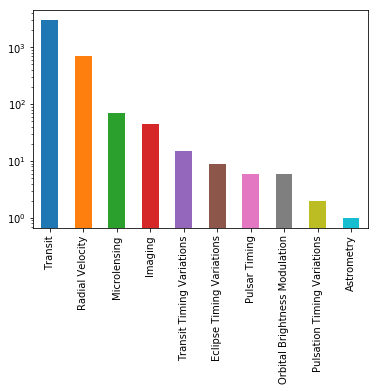

In [49]:
simple["pl_discmethod"].value_counts().plot.bar(logy=True)

Just poking around now... discovery method by date?

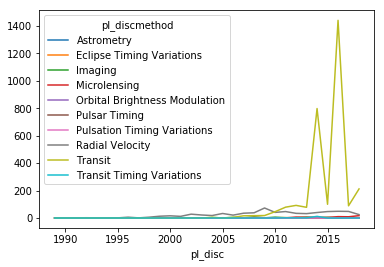

In [50]:
simple.reset_index().groupby(["pl_disc", "pl_discmethod"]).count()["pl_letter"].unstack("pl_discmethod").fillna(0).plot()

Wow— a lot of transits! Why is that?

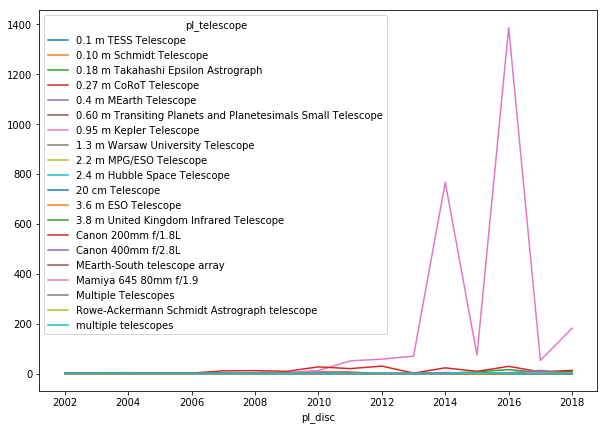

In [51]:
planets[planets["pl_discmethod"] == "Transit"].groupby(["pl_disc", "pl_telescope"]).count()["pl_letter"].unstack("pl_telescope").fillna(0).plot(figsize=(10, 7))

Oh. Kepler. The first peak corresponds to the Kepler telescope's first mission, which ended early in instrument failure. The second mission, K2, worked around the failure to get results until earlier this year.

Other than transits, what are the most popular methods?

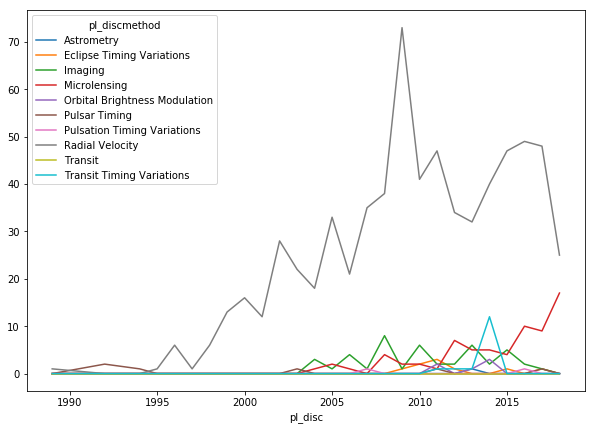

In [52]:
simple[simple["pl_discmethod"] != "Transit"].reset_index().groupby(["pl_disc", "pl_discmethod"]).count()["pl_letter"].unstack("pl_discmethod").fillna(0).plot(figsize=(10, 7))

Pulsar timing, apparently.

On to Dask!